In [1]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
# STEP 2: Load the Data
df = pd.read_csv('exchange_rate.csv')

In [8]:
# Parse date column and set it as index
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.set_index('date', inplace=True)

In [9]:
# Display first few rows
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


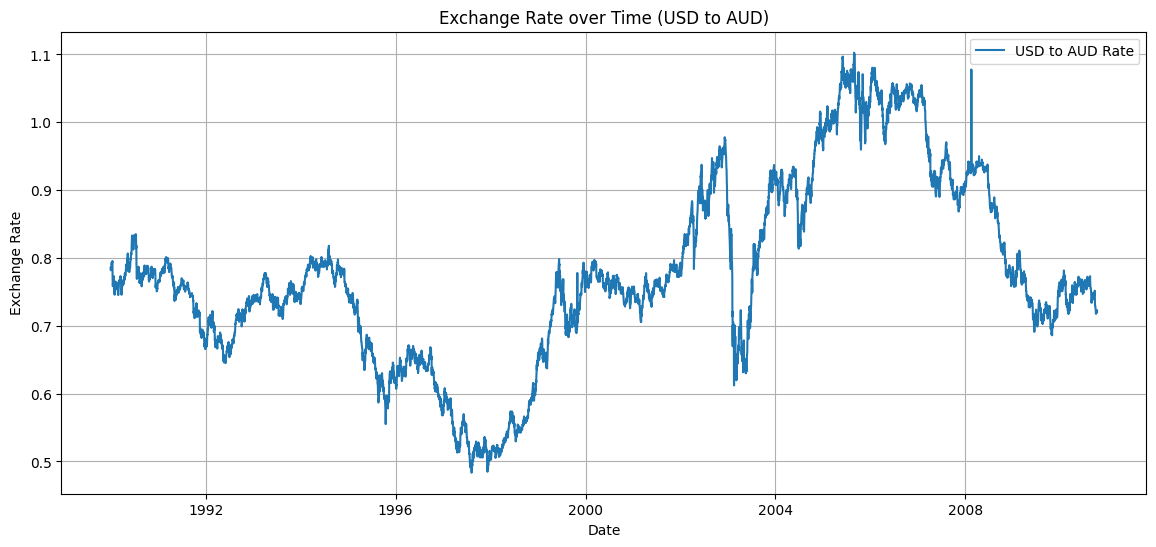

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [11]:
# STEP 3: Initial Exploration
# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(df['Ex_rate'], label='USD to AUD Rate')
plt.title('Exchange Rate over Time (USD to AUD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics
df['Ex_rate'].describe()

In [13]:
# 📌 STEP 4: Data Preprocessing

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Fill missing values using forward fill (can also try interpolation)
df['Ex_rate'] = df['Ex_rate'].fillna(method='ffill')

# Ensure frequency is daily
df = df.asfreq('D')

# Check again for missing values
print("Missing Values After Processing:\n", df.isnull().sum())

Missing Values:
 Ex_rate    0
dtype: int64
Missing Values After Processing:
 Ex_rate    0
dtype: int64


In [15]:
# 📌 STEP 5: Check Stationarity using Augmented Dickey-Fuller test
result = adfuller(df['Ex_rate'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
# If p-value > 0.05, data is non-stationary and needs differencing

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


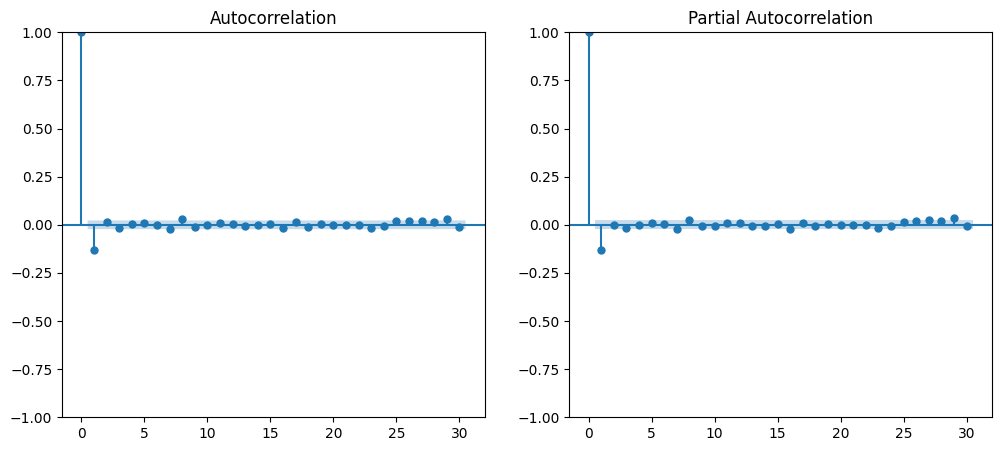

In [16]:
# 📌 STEP 6: ACF and PACF Plots for ARIMA parameter estimation
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(df['Ex_rate'].diff().dropna(), ax=plt.gca(), lags=30)
plt.subplot(122)
plot_pacf(df['Ex_rate'].diff().dropna(), ax=plt.gca(), lags=30)
plt.show()
# Use plots to estimate p and q (typically choose small values where correlation drops off)

In [17]:
# 📌 STEP 7: Fit ARIMA model
# Assuming (p,d,q) = (1,1,1) as a starting point
arima_model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Summary of the model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 15 Jul 2025   AIC                         -56102.322
Time:                        18:50:18   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

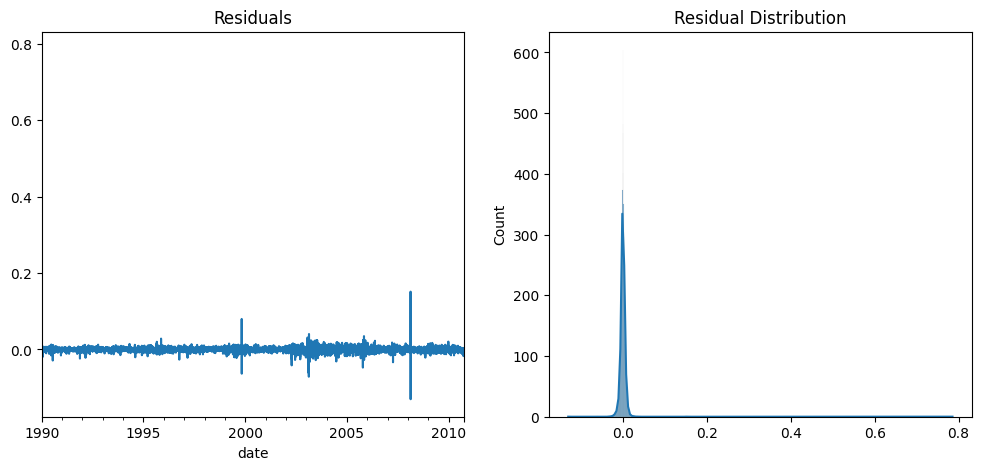

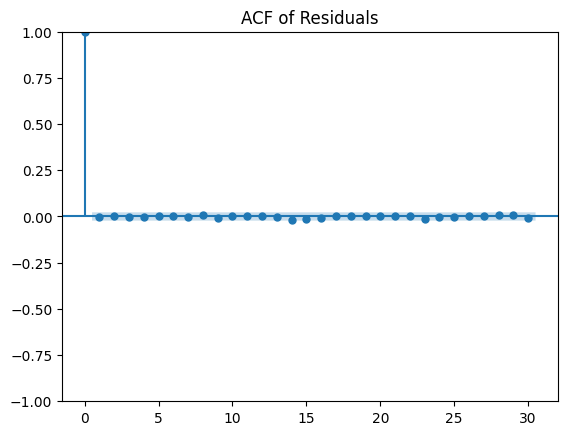

In [18]:
# 📌 STEP 8: ARIMA Residual Diagnostics
residuals = arima_result.resid

# Plot residuals
plt.figure(figsize=(12,5))
plt.subplot(121)
residuals.plot(title="Residuals")
plt.subplot(122)
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

# ACF of residuals
plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

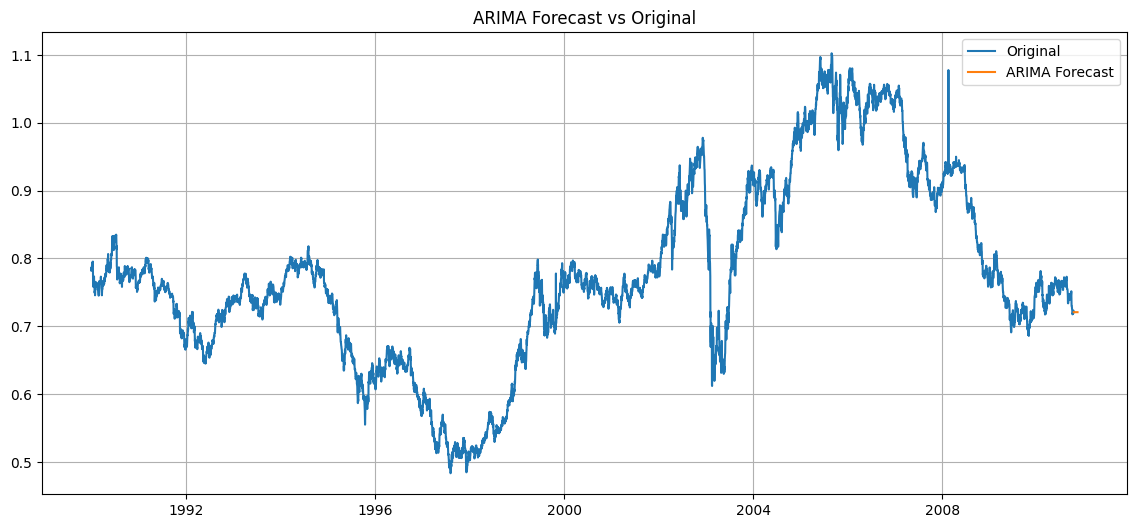

In [19]:
# 📌 STEP 9: Forecast using ARIMA
forecast_steps = 30  # next 30 days
arima_forecast = arima_result.forecast(steps=forecast_steps)

# Plot
plt.figure(figsize=(14,6))
plt.plot(df['Ex_rate'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], arima_forecast, label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Original")
plt.legend()
plt.grid(True)
plt.show()

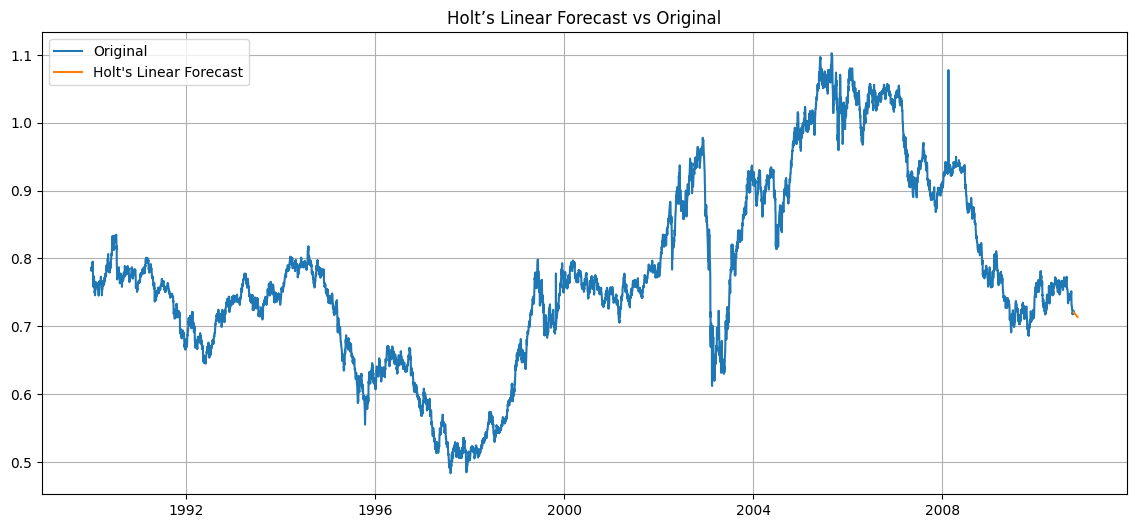

In [21]:
# 📌 STEP 10: Exponential Smoothing Model (Holt’s Linear Trend)
holt_model = Holt(df['Ex_rate'])
holt_fit = holt_model.fit()

# Forecast
holt_forecast = holt_fit.forecast(steps=30)

# Plot
plt.figure(figsize=(14,6))
plt.plot(df['Ex_rate'], label='Original')
plt.plot(holt_forecast.index, holt_forecast, label="Holt's Linear Forecast")
plt.title("Holt’s Linear Forecast vs Original")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# 📌 STEP 11: Evaluation Metrics for ARIMA and Holt
# For evaluation, let's split the last 30 days as test set
train = df.iloc[:-30]
test = df.iloc[-30:]

# Refit both models on train set
arima_model_train = ARIMA(train['Ex_rate'], order=(1,1,1)).fit()
arima_pred = arima_model_train.forecast(steps=30)

holt_model_train = Holt(train['Ex_rate']).fit()
holt_pred = holt_model_train.forecast(steps=30)

# Define error metrics
def evaluate_forecast(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = math.sqrt(mean_squared_error(true, predicted))
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate_forecast(test['Ex_rate'], arima_pred)
holt_mae, holt_rmse, holt_mape = evaluate_forecast(test['Ex_rate'], holt_pred)

# Display
print("🔹 ARIMA Metrics")
print(f"MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")

print("\n🔹 Holt’s Linear Metrics")
print(f"MAE: {holt_mae:.4f}, RMSE: {holt_rmse:.4f}, MAPE: {holt_mape:.2f}%")

🔹 ARIMA Metrics
MAE: 0.0135, RMSE: 0.0166, MAPE: 1.86%

🔹 Holt’s Linear Metrics
MAE: 0.0128, RMSE: 0.0155, MAPE: 1.76%


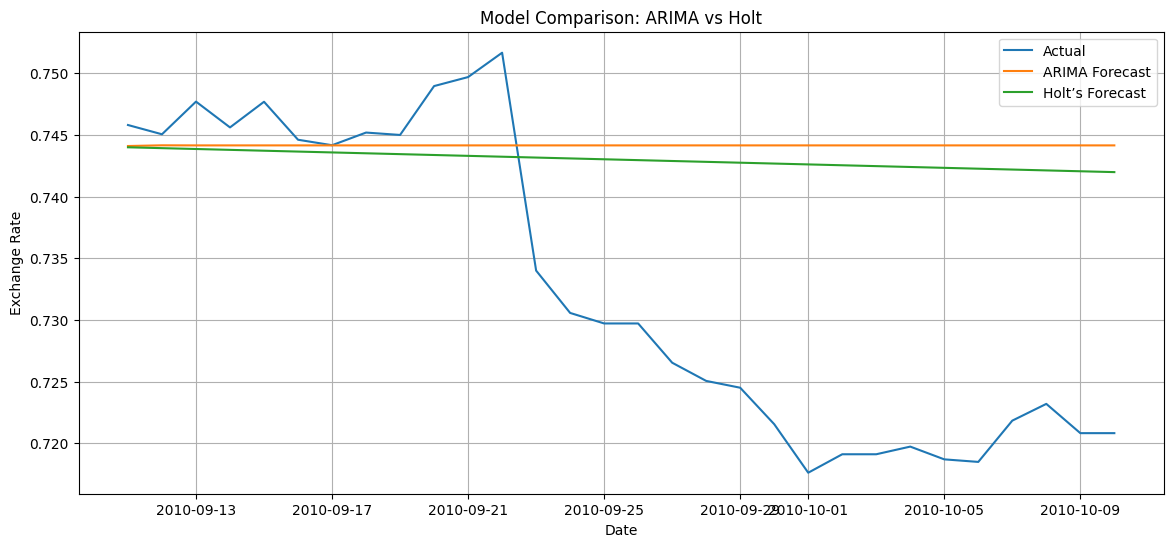

In [23]:
# 📌 STEP 12: Visual Comparison of Forecasts
plt.figure(figsize=(14,6))
plt.plot(test.index, test['Ex_rate'], label='Actual')
plt.plot(test.index, arima_pred, label='ARIMA Forecast')
plt.plot(test.index, holt_pred, label="Holt’s Forecast")
plt.title("Model Comparison: ARIMA vs Holt")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

## 📌 Conclusion

In this assignment, we analyzed historical exchange rates (USD to AUD) using two time series forecasting techniques: **ARIMA** and **Exponential Smoothing (Holt’s Linear Trend)**.

We began by exploring the dataset visually and statistically, identifying underlying patterns and addressing missing values. To prepare the data for ARIMA, we examined stationarity and selected appropriate model parameters using ACF and PACF plots. The fitted ARIMA model was further validated through residual diagnostics.

In parallel, we applied **Holt’s Linear Trend method** from the Exponential Smoothing family, as the data showed a trend but lacked obvious seasonality. Both models were then evaluated on a 30-day test set using standard performance metrics.

---

## ✅ Model Evaluation Summary

| Metric       | ARIMA        | Holt's Linear |
|--------------|--------------|---------------|
| MAE          | 0.0135       | 0.0128        |
| RMSE         | 0.0166       | 0.0155        |
| MAPE (%)     | 1.86%        | 1.76%         |

---

## 🔍 Insights:
- **ARIMA** provided slightly higher error metrics in this case, indicating that **Holt’s Linear** showed a marginally better fit for this dataset.
- **Holt’s Linear** is simpler to implement, faster to train, and showed good predictive power for the trend in exchange rates.
- For datasets with seasonality or more complex patterns, more advanced models such as **SARIMA** or **Facebook Prophet** could be explored.

---

## 📢 Final Recommendation:
Based on the evaluation metrics, **Holt’s Linear** model is recommended for this dataset due to its slightly better forecasting accuracy and simplicity. However, **ARIMA** remains a valuable method for capturing underlying data structures and may be preferred if additional complexities arise.


# 🙏 Thank You! 😊